# Imports

In [1]:
import os
import sys
sys.path.append("../")

import pandas as pd
pd.set_option('display.max_columns', 10000)

#Audio Processing Libraries
import librosa
from scipy import signal
#For Playing Audio
import IPython.display as ipd
#Array Processing
import numpy as np
#Data Visualization
import matplotlib.pyplot as plt


[GTZAN](http://opihi.cs.uvic.ca/sound/genres.tar.gz)

+ Description:
L'ensemble de données se compose de 1000 pistes audio d'une durée de 30 secondes. 

Il contient 10 genres, chacun représenté par 100 pistes. 

Les pistes sont toutes des fichiers audio mono 16 bits à 22050 Hz au format .wav.

Les genres sont :

+ blues
+ classique
+ country
+ disco
+ hip hop
+ jazz
+ metal
+ pop
+ reggae
+ rock

# Préparation des données

Le sample rate (taux d'échantillonage) correspond à la moyenne du nombre d'échantillons capturés en 1 seconde. 

Afin de constituer les données d'entrainements, chaque piste audio est découpée en piste de *n* secondes avec un pas de *m* secondes. 
(e.g., pour *n=4* et *m=2* : de 0 à 4 secondes, de 2 à 6 secondes ...).

Chaque piste audio de *n* secondes correspond à un array de taille [sample rate * *n*]

In [2]:
from pathlib import Path

def prepare_data(samples, num_of_samples, sample_rate, f_path, genre, step):
  """Divide audio files into smaller chinks.

  Returns:
      list containing ndArrays corresponding to chunks 
  """
  # extract filename from the file path
  filename = Path(f_path).stem.strip('.wav')
  data = []
  data_row ={}
  i = 0
  # divide data into chunks with a step equal to [sample rate * 2]
  for offset in range(0, len(samples), sample_rate * step):
    start = offset
    end   = offset + num_of_samples
    chunk = samples[start:end]
    if(len(chunk)==num_of_samples):
      data_row = {'filename': f"{filename}_{i}", 'chunk': chunk, 'sample_rate': sample_rate, 'genre': genre}
      data.append(data_row)
      i += 1
  return data


In [3]:
from scipy.io import wavfile

step = 2
duration = 4

df = pd.DataFrame()

genres_dir = "../data/01/genres"

genres = os.listdir(genres_dir)
# loop throught genres
for genre in genres:
    files = os.listdir(os.path.join(genres_dir, genre))
    # loop throught files
    for f in files:
        f_path = os.path.join(genres_dir, genre, f)
        samplerate, data = wavfile.read(f_path)
        num_of_samples = samplerate * duration
        chunks = prepare_data(data, num_of_samples, samplerate, f, genre, step)
        df = df.append(chunks)

df = df.reset_index(drop=True)
df.shape

(13991, 4)

In [4]:
df.sample(1)

,filename,chunk,sample_rate,genre
13256,blues.00044_7,"[727, 689, 985, 1098, -345, -1184, -1049, -205...",22050,blues


In [5]:
df.genre.value_counts()


pop          1400
reggae       1400
blues        1400
jazz         1400
metal        1400
rock         1399
disco        1399
classical    1398
hiphop       1398
country      1397
Name: genre, dtype: int64

In [6]:
metal_preview = df.iat[7449, 1]  # chunk of metal track
pop_preview = df.iat[12116, 1]   # chunk of pop track

In [7]:
# from scipy.io import wavfile
# import matplotlib.pyplot as plt

# plt.figure(figsize=(20, 4))
# plt.plot(np.linspace(0, 5, num=len(metal_preview)), metal_preview)
# plt.title('Metal track visualization')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')
# plt.figure(figsize=(20, 4))
# plt.plot(np.linspace(0, 5, num=len(pop_preview)), pop_preview)
# plt.title('Pop track visualization')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')
# _ = plt.show()



In [8]:
sample_rate = 22050
metal_preview_path = "../data/chunk_audio_preview/metal_preview.wav"
pop_preview_path = "../data/chunk_audio_preview/pop_preview.wav"

metal_audio = wavfile.write(metal_preview_path, sample_rate, metal_preview)
pop_audio = wavfile.write(pop_preview_path, sample_rate, pop_preview)


In [9]:
from playsound import playsound

playsound(metal_preview_path)
playsound(pop_preview_path)


playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


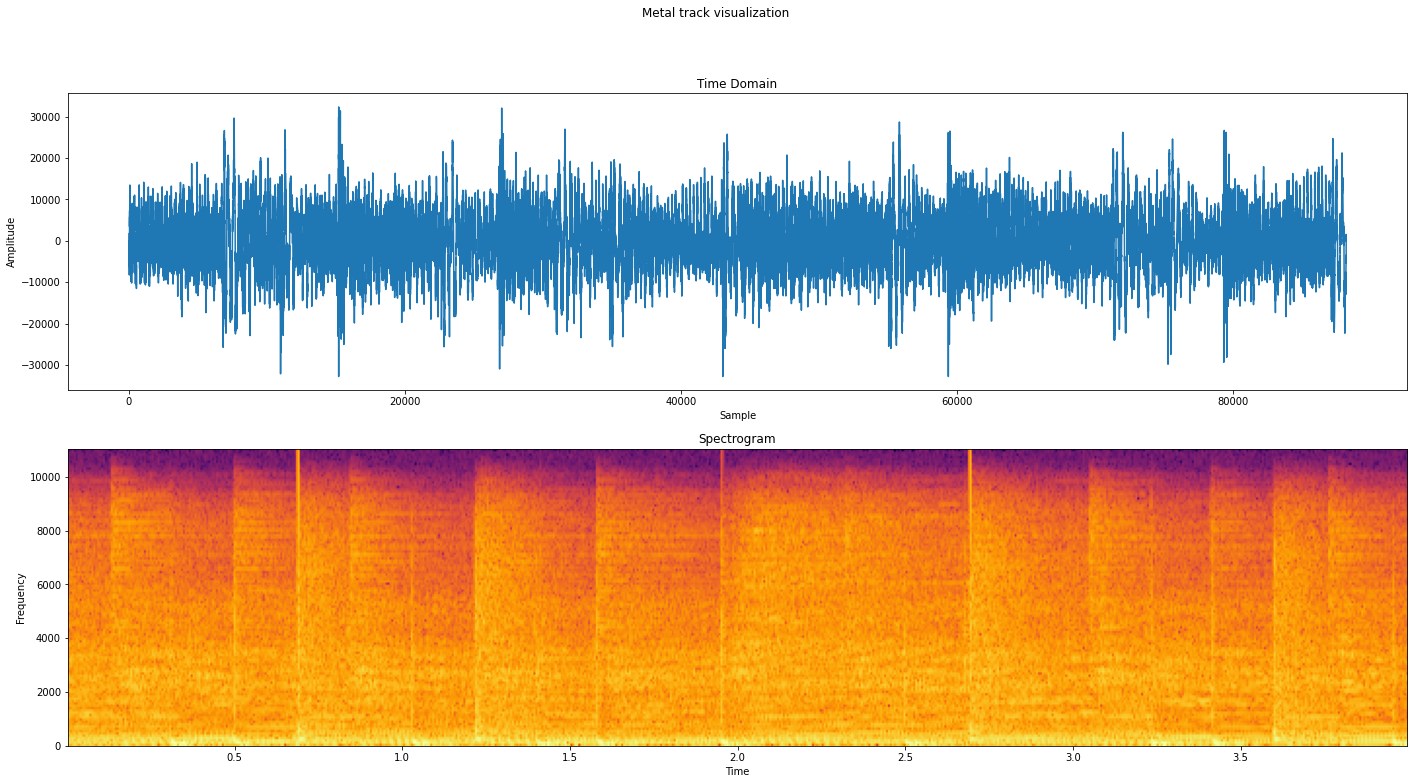

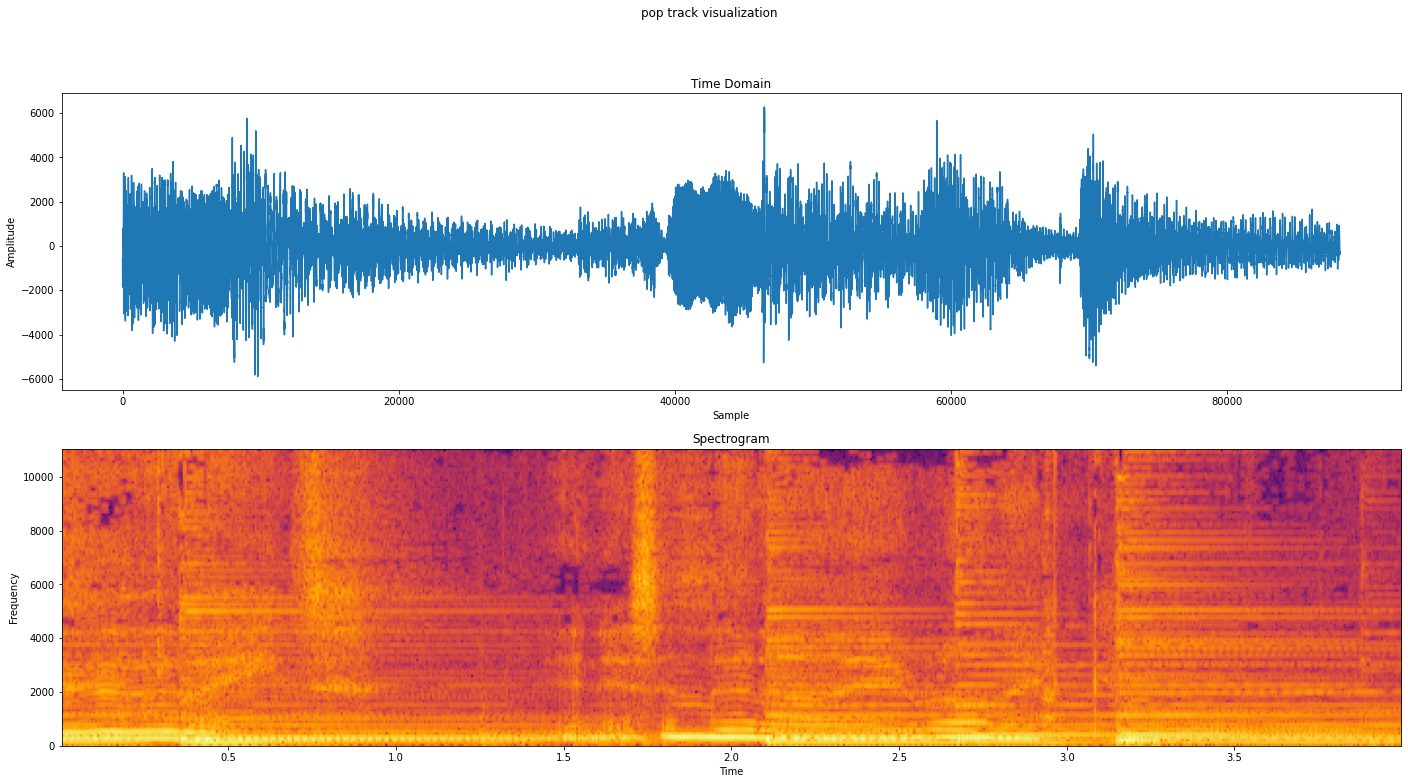

In [10]:
metal_rate, metal_samples = wavfile.read(metal_preview_path)
pop_rate, pop_samples = wavfile.read(pop_preview_path)

plt.figure(figsize=(24,12))
plt.set_cmap('Dark2')
plt.suptitle('Metal track visualization')

plt.subplot(211)
plt.title('Time Domain')
plt.plot(metal_samples)
plt.xlabel('Sample')
plt.ylabel('Amplitude')


plt.subplot(212)
plt.title("Spectrogram")
plt.specgram(metal_samples, Fs=metal_rate, cmap="inferno")
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.figure(figsize=(24, 12))
plt.suptitle('pop track visualization')

plt.subplot(211)
plt.title('Time Domain')
plt.plot(pop_samples)
plt.xlabel('Sample')
plt.ylabel('Amplitude')


plt.subplot(212)
plt.title("Spectrogram")
plt.specgram(pop_samples, Fs=pop_rate, cmap="inferno")
plt.xlabel('Time')
plt.ylabel('Frequency')

_ = plt.show()
# 'psd', 'magnitude', 'angle', 'phase'


In [12]:
df.to_csv('../data/02/chunks.csv', index=False)

Le jeu d'entrainement est maintenant constitué de 13991 pistes audio (environ 1400 par genre musical)

In [21]:
df = pd.read_csv('../data/02/chunks.csv')
print(f"Le jeu d'entrainement est maintenant constitué de {df.shape[0]} pistes audio (environ {round(df.genre.value_counts().mean())} par genre musical)")

Le jeu d'entrainement est maintenant constitué de 13991 pistes audio (environ 1399 par genre musical)


In [23]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.chunk, df.genre, random_state=777, shuffle=True, stratify=df.genre)


y_train.value_counts(), y_test.value_counts()

(pop          1050
 reggae       1050
 blues        1050
 jazz         1050
 metal        1050
 rock         1049
 disco        1049
 classical    1049
 country      1048
 hiphop       1048
 Name: genre, dtype: int64,
 rock         350
 jazz         350
 metal        350
 reggae       350
 disco        350
 blues        350
 pop          350
 hiphop       350
 country      349
 classical    349
 Name: genre, dtype: int64)